In [4]:
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
import os
import sys
import matplotlib.pyplot as plt
from collections import deque
import random
import seaborn as sns
sns.set()
tf.disable_v2_behavior()

In [5]:
df = pd.read_csv('dataset/GOOG.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-08-12,242.212219,247.622620,241.496490,246.251251,246.251251,4404700
1,2010-08-13,244.744751,245.840836,243.248245,243.418411,243.418411,3865500
2,2010-08-16,242.082077,245.180176,240.490494,243.038040,243.038040,2607300
3,2010-08-17,244.509506,247.597595,243.258255,245.505508,245.505508,3777600
4,2010-08-18,245.465469,245.680679,241.016022,241.316315,241.316315,5367400


In [6]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1

In [7]:
class neuralnetwork:
    def __init__(self, id_, hidden_size = 128):
        self.W1 = np.random.randn(window_size, hidden_size) / np.sqrt(window_size)
        self.W2 = np.random.randn(hidden_size, 3) / np.sqrt(hidden_size)
        self.fitness = 0
        self.id = id_

def relu(X):
    return np.maximum(X, 0)
    
def softmax(X):
    e_x = np.exp(X - np.max(X, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def feed_forward(X, nets):
    a1 = np.dot(X, nets.W1)
    z1 = relu(a1)
    a2 = np.dot(z1, nets.W2)
    return softmax(a2)

In [8]:
class NeuroEvolution:
    def __init__(self, population_size, mutation_rate, model_generator,
                state_size, window_size, trend, skip, initial_money):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.model_generator = model_generator
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        
    def _initialize_population(self):
        self.population = []
        for i in range(self.population_size):
            self.population.append(self.model_generator(i))
    
    def mutate(self, individual, scale=1.0):
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W1.shape)
        individual.W1 += np.random.normal(loc=0, scale=scale, size=individual.W1.shape) * mutation_mask
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W2.shape)
        individual.W2 += np.random.normal(loc=0, scale=scale, size=individual.W2.shape) * mutation_mask
        return individual
    
    def inherit_weights(self, parent, child):
        child.W1 = parent.W1.copy()
        child.W2 = parent.W2.copy()
        return child
    
    def crossover(self, parent1, parent2):
        child1 = self.model_generator((parent1.id+1)*10)
        child1 = self.inherit_weights(parent1, child1)
        child2 = self.model_generator((parent2.id+1)*10)
        child2 = self.inherit_weights(parent2, child2)
        # first W
        n_neurons = child1.W1.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W1[:, cutoff:] = parent2.W1[:, cutoff:].copy()
        child2.W1[:, cutoff:] = parent1.W1[:, cutoff:].copy()
        # second W
        n_neurons = child1.W2.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W2[:, cutoff:] = parent2.W2[:, cutoff:].copy()
        child2.W2[:, cutoff:] = parent1.W2[:, cutoff:].copy()
        return child1, child2
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def act(self, p, state):
        logits = feed_forward(state, p)
        return np.argmax(logits, 1)[0]
    
    def buy(self, individual,date1,close):
        initial_money = self.initial_money
        date1 = date1
        starting_money = initial_money
        state = self.get_state(0)
        inventory = []
        states_sell = []
        states_buy = []
        
        for t in range(0, len(close) - 1, self.skip):
            action = self.act(individual, state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= close[t]:
                inventory.append(close[t])
                initial_money -= close[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, close[t], initial_money))
                df1 = pd.DataFrame({'Date': date1[t+1], 'Close': [close[t+1]],'RESULT': ['Buy'] })
                if not os.path.isfile('output/21.neuro-evolution-agent.csv'):
                    df1.to_csv('output/21.neuro-evolution-agent.csv', index=False)
                else:
                    df1.to_csv('output/21.neuro-evolution-agent.csv', index=False, mode='a', header=False)
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += close[t]
                states_sell.append(t)
                try:
                    invest = ((self.trend[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
                df2 = pd.DataFrame({'Date': date1[t+1], 'Close': [close[t+1]],'RESULT': ['Sell'] })
                if not os.path.isfile('output/21.neuro-evolution-agent.csv'):
                    df2.to_csv('output/21.neuro-evolution-agent.csv', index=False)
                else:
                    df2.to_csv('output/21.neuro-evolution-agent.csv', index=False, mode='a', header=False)
            else:
                print(
                    'day %d, hold UNIT at price %f,  total balance %f,'
                    % (t+1, close[t+1], initial_money)
                )
                df3 = pd.DataFrame({'Date': date1[t+1], 'Close': [close[t+1]], 'RESULT': ['Hold']})
                if not os.path.isfile('output/21.neuro-evolution-agent.csv'):
                    df3.to_csv('output/21.neuro-evolution-agent.csv', index=False)
                else:
                    df3.to_csv('output/21.neuro-evolution-agent.csv', index=False, mode='a', header=False)
            
            state = next_state
            
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        print(
                '\ntotal gained %f, total investment %f %%'
                % (initial_money - starting_money, invest)
            )
    
    def calculate_fitness(self):
        for i in range(self.population_size):
            initial_money = self.initial_money
            starting_money = initial_money
            state = self.get_state(0)
            inventory = []
            
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(self.population[i], state)
                next_state = self.get_state(t + 1)
            
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]

                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    starting_money += self.trend[t]

                state = next_state
            invest = ((starting_money - initial_money) / initial_money) * 100
            self.population[i].fitness = invest
    
    def evolve(self, generations=20, checkpoint= 5):
        self._initialize_population()
        n_winners = int(self.population_size * 0.4)
        n_parents = self.population_size - n_winners
        for epoch in range(generations):
            self.calculate_fitness()
            fitnesses = [i.fitness for i in self.population]
            sort_fitness = np.argsort(fitnesses)[::-1]
            self.population = [self.population[i] for i in sort_fitness]
            fittest_individual = self.population[0]
            if (epoch+1) % checkpoint == 0:
                print('epoch %d, fittest individual %d with accuracy %f'%(epoch+1, sort_fitness[0], 
                                                                          fittest_individual.fitness))
            next_population = [self.population[i] for i in range(n_winners)]
            total_fitness = np.sum([np.abs(i.fitness) for i in self.population])
            parent_probabilities = [np.abs(i.fitness / total_fitness) for i in self.population]
            parents = np.random.choice(self.population, size=n_parents, p=parent_probabilities, replace=False)
            for i in np.arange(0, len(parents), 2):
                child1, child2 = self.crossover(parents[i], parents[i+1])
                next_population += [self.mutate(child1), self.mutate(child2)]
            self.population = next_population
        return fittest_individual

In [9]:
population_size = 100
generations = 100
mutation_rate = 0.1
neural_evolve = NeuroEvolution(population_size, mutation_rate, neuralnetwork,
                              window_size, window_size, close, skip, initial_money)

In [10]:
fittest_nets = neural_evolve.evolve(1)

In [11]:
date = df.Date.values.tolist()
neural_evolve.buy(fittest_nets,date1=date,close=close)

day 3: buy 1 unit at price 245.505508, total balance 9754.494492
day 5: buy 1 unit at price 234.219223, total balance 9520.275269
day 6, sell 1 unit at price 231.241241, investment -5.810162 %, total balance 9751.516510,
day 7, sell 1 unit at price 232.267273, investment -0.833386 %, total balance 9983.783783,
day 12: buy 1 unit at price 226.571579, total balance 9757.212204
day 13, sell 1 unit at price 225.235229, investment -0.589814 %, total balance 9982.447433,
day 14: buy 1 unit at price 230.395401, total balance 9752.052032
day 15: buy 1 unit at price 231.821823, total balance 9520.230209
day 16, sell 1 unit at price 235.385391, investment 2.165838 %, total balance 9755.615600,
day 18, sell 1 unit at price 235.525528, investment 1.597652 %, total balance 9991.141128,
day 19: buy 1 unit at price 238.328323, total balance 9752.812805
day 20, sell 1 unit at price 238.308304, investment -0.008400 %, total balance 9991.121109,
day 21: buy 1 unit at price 241.376373, total balance 9749

day 950: buy 1 unit at price 555.450012, total balance -2111.808083
day 951, sell 1 unit at price 563.799988, investment -5.352770 %, total balance -1548.008095,
day 954: buy 1 unit at price 570.559998, total balance -2118.568093
day 955: buy 1 unit at price 571.650024, total balance -2690.218117
day 956, sell 1 unit at price 564.340027, investment -6.029553 %, total balance -2125.878090,
day 957, sell 1 unit at price 554.510010, investment -8.503646 %, total balance -1571.368080,
day 958: buy 1 unit at price 553.760010, total balance -2125.128090
day 959: buy 1 unit at price 564.929993, total balance -2690.058083
day 960, sell 1 unit at price 566.030029, investment -7.240918 %, total balance -2124.028054,
day 965, sell 1 unit at price 560.349976, investment -7.846731 %, total balance -1563.678078,
day 967: buy 1 unit at price 550.619995, total balance -2114.298073
day 968: buy 1 unit at price 560.659973, total balance -2674.958046
day 969, sell 1 unit at price 564.989990, investment -

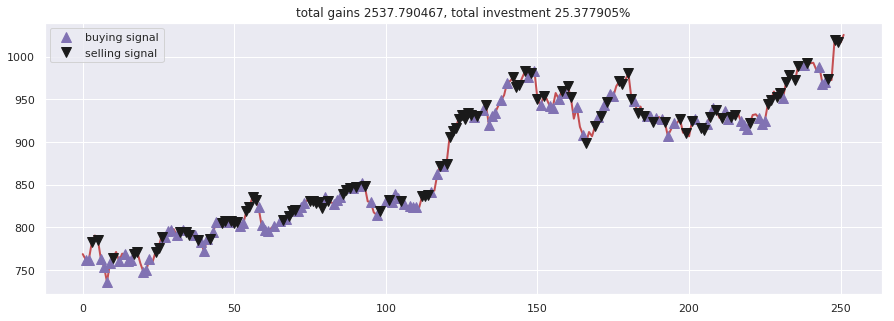

In [9]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()